## Hierarchical Bayesian Modeling to assess tribal knowledge

In this analysis, we aim to develop a methodology and data-driven metric to identify potential technological risks within an organization's coding practices. We will explore the utilisation of programming languages across various projects and repositories, mirroring those found in code repositories such as GitHub. Our approach employs Hierarchical Bayesian Modelling (HBM) for multi-level data analysis, with a keen focus on the effects of programming languages within individual repositories.

While our primary interest lies in understanding language effects at the repository level, we also place significant emphasis on the aggregate usage of languages organisation-wide. This dual focus allows us to capture not only repository-specific variances but also overarching language trends, thereby providing a nuanced "risk" metric for Enterprise Architecture. Such a metric enables organisations to identify potential knowledge silos, thereby informing strategic decisions aimed at enhancing project continuity and organisational adaptability.

By analysing language usage across different organisational strata and integrating measures of uncertainty, HBM aims to expose pockets of siloed tribal knowledge. While initially focusing on language use, this methodology can be expanded to include other metrics, such as the number of commits, time since the last commit, total commits, and more. This approach is crucial for unveiling hidden risks within the architectural framework by uncovering potential vulnerabilities. It facilitates a comparison of language usage at the repository level against broader organisational patterns, offering insights into scenarios where a specific programming language may appear marginal in isolation but emerges as a significant risk in the broader organisational context due to limited expertise or exposure.

Consider, for example, a scenario where a single repository predominantly uses Lua, a language not widely adopted in broader enterprise contexts. Our Hierarchical Bayesian Modelling evaluates the risk by meticulously examining Lua's application within the repository, its relevance to the overarching project, and its prevalence within the organisation. This comprehensive assessment is pivotal in ascertaining whether Lua's usage aligns with the enterprise's technological trajectory and knowledge base, thereby guiding strategic architectural decisions and reinforcing organisational resilience in the face of technological evolution.

#### Flow
To start building a hierarchical Bayesian model using PyMC3 based on your JSON data, you'll first need to parse the data to extract the relevant information for modelling. This involves aggregating language usage across repositories and projects. After that, we define a hierarchical model that captures the variability within repositories and commonalities across projects.

* Data Preparation: Aggregate the language bytes for each language across all repositories and projects.
* Model Definition: Define a hierarchical model in Pymc, using project-level priors influencing repository-level distributions.
* Inference: Use MCMC provided by pymc to sample from the posterior distribution.
* Analysis: Analyze the posterior distributions to identify languages with usage outside the credible regions.

In [80]:
# Import required packages

import pandas as pd
import numpy as np
import pymc as pm
import graphviz
import arviz as az
import pprint 
from ridgeplot import ridgeplot
import matplotlib as plt
import warnings

from utils import load_data, json2pandas


## Pre-Processing
The first step is to run the `generate_dummy_data.py` file to make sure we have data to play around with, the generated dummy data is similar to what you might pull from GitHub's REST API for repository languages https://docs.github.com/en/rest/repos/repos?apiVersion=2022-11-28#list-repository-languages

```GitHub CLI api
https://cli.github.com/manual/gh_api

gh api \
  -H "Accept: application/vnd.github+json" \
  -H "X-GitHub-Api-Version: 2022-11-28" \
  /repos/OWNER/REPO/languages

Example Response:
{
  "C": 78769,
  "Python": 7769
}
```



From here, we can load and transform the data. 

In [81]:
df_json = load_data("data/dummy_language_data.json")
# Prety print some Projects and Repos randomly to visualise the data
NUM_PROJECTS = 1
first_N_projects = {k: df_json[k] for k in list(df_json)[:NUM_PROJECTS]}
pp = pprint.PrettyPrinter(depth=3)
pp.pprint(first_N_projects)

{'Project_1': {'Repo_1': {'C#': 1373390,
                          'Groovy': 3208,
                          'Java': 3208233,
                          'Kotlin': 1241510,
                          'Lua': 24122,
                          'Rust': 475136,
                          'SQL': 903102},
               'Repo_2': {'Bash': 129152,
                          'Elixir': 74906,
                          'Go': 127016,
                          'JavaScript': 97343,
                          'Kotlin': 201302,
                          'Python': 527544,
                          'Rails': 18664,
                          'TypeScript': 53918},
               'Repo_3': {'Rust': 755603, 'Scala': 7693879},
               'Repo_4': {'Python': 1432726},
               'Repo_5': {'C++': 574406, 'PHP': 673745, 'Python': 884138},
               'Repo_6': {'Bash': 2029433,
                          'JavaScript': 2675468,
                          'Swift': 153707},
               'Repo_7': {'C++': 2186

Let's flip this into a normal dataset we are used to, and and a new variable to log transform the byte count.

In [82]:
df=json2pandas(df_json)
# Using pandas to calculate the logarithm of the ByteCount column
df['logByteCount'] = np.log(df['ByteCount'])
# Creating a new column Project_Repo by concatenating Project and Repository columns
df['Unique_Repo'] = df['Project'] + "_" + df['Repository']

columns_to_encode = ['Project', 'Language', 'Repository', 'Unique_Repo']

# Loop over the columns to encode
for column_name in columns_to_encode:
    # Cast each column to Categorical and add it as a new column with a suffix '_codes'
    df[f'{column_name}_codes'] = df[column_name].astype('category').cat.codes

print("Total number of projects:", df['Project'].unique().shape)
print("Total number of projects repo ids:", df['Unique_Repo_codes'].unique().shape)

Total number of projects: (50,)
Total number of projects repo ids: (664,)


In [83]:
df.head(10)

Project Repository Language  ByteCount  logByteCount       Unique_Repo  \
0  Project_1     Repo_1     Java    3208233     14.981231  Project_1_Repo_1   
1  Project_1     Repo_1      SQL     903102     13.713591  Project_1_Repo_1   
2  Project_1     Repo_1   Groovy       3208      8.073403  Project_1_Repo_1   
3  Project_1     Repo_1     Rust     475136     13.071356  Project_1_Repo_1   
4  Project_1     Repo_1       C#    1373390     14.132793  Project_1_Repo_1   
5  Project_1     Repo_1      Lua      24122     10.090880  Project_1_Repo_1   
6  Project_1     Repo_1   Kotlin    1241510     14.031839  Project_1_Repo_1   
7  Project_1     Repo_2     Bash     129152     11.768745  Project_1_Repo_2   
8  Project_1     Repo_2   Kotlin     201302     12.212562  Project_1_Repo_2   
9  Project_1     Repo_2   Python     527544     13.175988  Project_1_Repo_2   

   Project_codes  Language_codes  Repository_codes  Unique_Repo_codes  
0              0              16                 0                100  
1              0              32                 0                100  
2              0              13                 0                100  
3              0              31                 0                100  
4              0               2                 0                100  
5              0              20                 0                100  
6              0              19                 0                100  
7              0               1                11                101  
8              0              19                11                101  
9              0              27                11                101

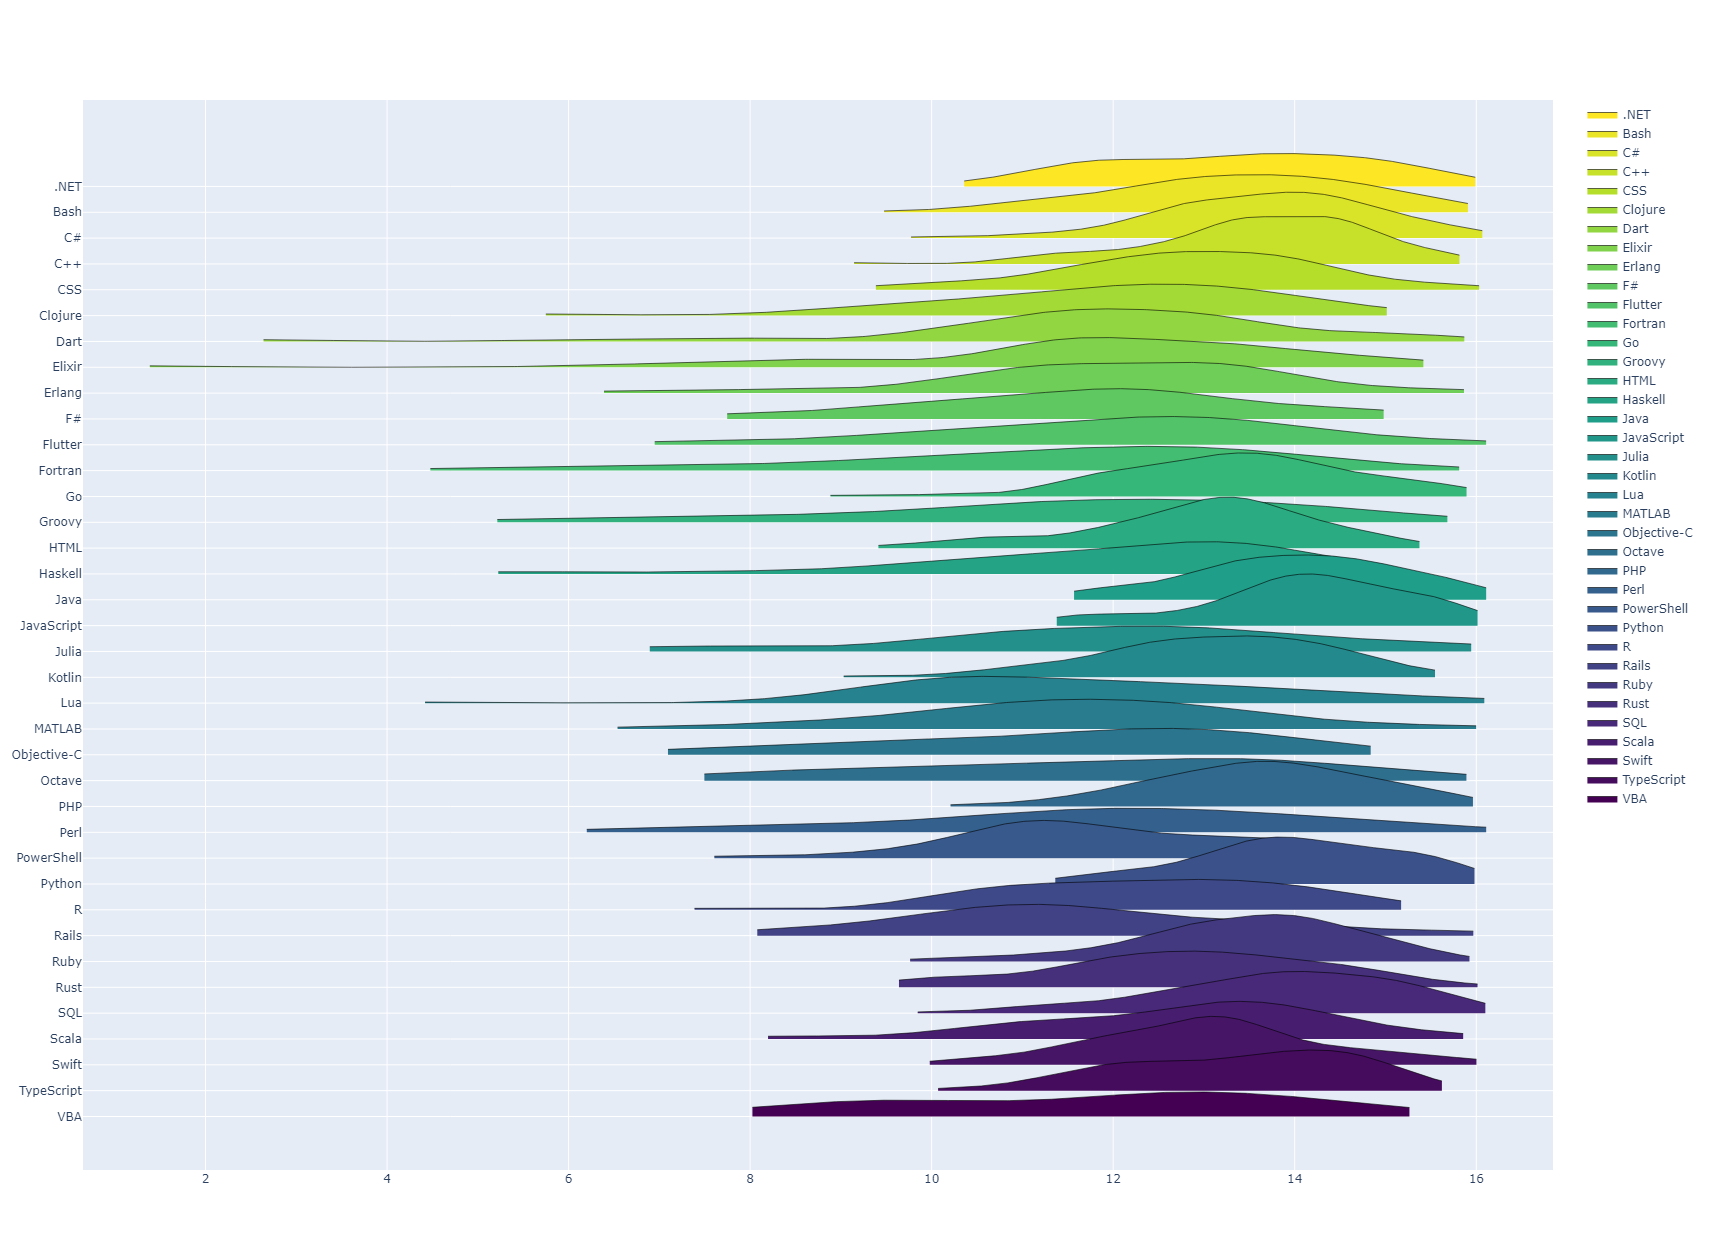

In [84]:
# Group by 'Language' and create a list of log byte counts for each language
grouped = df.groupby('Language')['logByteCount'].apply(list).to_dict()

# Prepare samples for ridge plot
samples = [np.array(grouped[language]) for language in grouped]
fig = ridgeplot(samples=samples, labels=list(grouped.keys()), colorscale="viridis", colormode="row-index",)
fig.update_layout(height=1250, width=800)

fig.show()

## Hierarchical Model Specification

This section introduces Hierarchical Bayesian Modelling (HBM) principles and their application in structuring complex, multi-level datasets, such as those encountered in evaluating technological risks within coding languages.

#### Introduction to Hierarchical Bayesian Modelling
Hierarchical Bayesian Modelling is a statistical framework that facilitates data analysis across different levels of hierarchy by integrating the variability within individual units, such as repositories, and observing commonalities that may emerge. At the core of Bayesian inference is Bayes' theorem, which updates the probability for a hypothesis by introducing new evidence. A fundamental concept in HBM is exchangeability, suggesting that data points are probabilistically interchangeable. This characteristic makes it particularly suited for modelling datasets without a natural ordering but considered identically distributed given some parameters.

Our analysis delves into programming language usage within repositories, examining the ByteCount—the code volume per language in each repository. We adopt distributions like the Negative Binomial to model count data, framing our approach as a Hierarchical Negative Binomial Model. This model explicitly addresses the intricacies of language usage within repositories, adding a novel layer by considering the impact of language diversity per repository on language prevalence.

- **Repository-Level Language likelihood:** The effects of specific programming languages within repositories are central to our analysis. We model these effects to capture the observed code volume across languages, incorporating a likelihood function that accounts for data variability and dispersion:

  $$ P(Language_{ij} | \theta_{ij}) \sim NegativeBinomial(\mu_{ij}, \alpha)$$

  Here, \$ \theta_{ij} \$ represents the expected byte count for language usage, where \$( i \)$ denotes the repository and \$(j)\$ the language. $\( \mu_{ij} \)$ is the mean parameter, and $\( \alpha \)$ is the dispersion parameter of the Negative Binomial distribution, modelling the count data's overdispersion within each repository for each language.

- **Language Count Priors:**  Reflecting our initial beliefs about code distribution across programming languages within repositories, our model establishes language count priors:

  $$ \mu_i \sim LogNormal(\log(\mu), \sigma^2) $$

  This LogNormal distribution for $ \mu_i \ $ allows us to model the mean language counts on a log scale, accommodating the wide range of byte counts observed across languages.

- **Language Diversity and Interaction Effects:** A novel aspect of our model focuses on the total number of programming languages present in each repository and their influence on the prevalence of specific languages. This analysis allows us to explore whether repositories with a greater variety of languages exhibit distinct patterns in language usage compared to those with fewer languages.
    $$log\_mu = \log(diversity\_effect_{i} + language\_effect_{j})$$
where
    - **Diversity Effect:** The effect of language diversity within repositories is modelled quantitatively to predict the prevalence of specific languages. We hypothesise that a higher diversity of languages might correlate with unique language patterns, which is captured by the following equation:
    $$ diversity\_effect \sim Normal(0, \sigma_{diversity}) $$
      
    - **Inferred Interaction Effects:** Our model infers interactions between languages based on their co-occurrence within repositories to capture the nuanced dynamics of language co-occurrence. This approach allows for identifying emergent patterns that are not explicitly defined by predefined affinities but discovered through data analysis. The inferred interaction effects can be conceptually represented as:

    $$ interaction\_effect \sim Normal(0, \sigma_{interaction}) $$

The inclusion of language diversity and the potential for inferred interaction effects between languages are modelled implicitly within the log_mu formulation. This allows us to explore how diverse language environments within repositories might influence the prevalence of specific languages, either amplifying or mitigating their usage based on the repository's unique language composition.    
  
- **Organisational-Level Hyperpriors:** To complement our repository-level analysis, we incorporate organisational-level hyperpriors, which allow us to gauge broader patterns in language usage across all projects and repositories. These hyperpriors help us capture the overall landscape of organisational programming language utilisation, providing insights into commonality and variance that might not be apparent from isolated repository-level data.

  $$ \mu_i \sim Beta(a_{\mu}, b_{\mu}) $$
  $$ \kappa_i \sim Gamma(a_{\kappa}, b_{\kappa}) $$

Here, $ \mu_i $ and $ \kappa_i $ are hyperpriors for the mean and dispersion of language usage organisation-wide. By mirroring our foundational assumptions regarding language prevalence and variability, these hyperpriors afford a nuanced perspective on how individual languages align with or deviate from overarching organisational trends. This analytical layer is pivotal for spotlighting languages that may be less visible within individual repositories but hold significant implications for the organisational technology stack, informing strategic development and risk mitigation.

#### An English explanation of our model

- **Negative Binomial Distribution for Count Data:** It employs the Negative Binomial distribution to model the number of bytes of code (ByteCount) for different programming languages in each repository. This choice is due to the distribution's ability to handle overdispersion in count data, which is common when looking at code volumes.

- **Model Components:**
    - **Language Likelihood** at the Repository Level: It calculates the likelihood of observing specific amounts of code in different languages within each repository. This part of the model considers the mean amount of code and its variance, acknowledging that code volume can vary widely even within the same language across different repositories.
    - **Language Count Priors:** The model sets initial assumptions about how code is distributed among languages within repositories, using a LogNormal distribution. This reflects the belief that while some languages might have large volumes of code (hence the logarithmic scale), the exact distribution is initially uncertain.
    - **Language Diversity and Interaction Effects:** An innovative aspect of the model is its focus on the diversity of programming languages within a repository and how this diversity might affect the prevalence of specific languages. It suggests repositories with more languages might show different usage patterns than those with fewer languages. This is modelled implicitly through a combination of effects (log_mu) that include the impact of language diversity and potential interactions between languages based on their co-occurrence.
    - **Organizational-Level Hyperpriors:* Beyond individual repositories, the model also considers language usage patterns across the entire organisation. It uses hyperpriors to capture broad trends and variations in language use, helping identify strategic insights, such as underutilised languages or potential knowledge silos.
      
- **Objective of the Model:** The ultimate goal is to extract actionable insights about an organisation's technological landscape. By analysing language usage at the granular level of repositories and in the context of the broader organisational environment, the model helps identify areas for strategic development, risk mitigation, and resource allocation. It highlights prevalent languages and sheds light on the implications of language diversity and interaction within the organisation's coding practices.



## Transitioning to Posterior Distributions

### From Theory to Practice: The Role of Posterior Distributions

With our model parameters defined and their priors set, the next step in Bayesian analysis is to update these beliefs with observed data. This is where the posterior distribution comes into play.


#### What is the posterior?

In the hierarchical Bayesian modelling (HBM) context, the posterior distribution is the updated belief about our model's parameters after considering the observed data. It combines our prior beliefs (the priors) and the evidence from the data (the likelihood). Mathematically, it is expressed as:

$$
P(\theta | data) \propto P(data | \theta) \times P(\theta)
$$

Where:
- \($ P(\theta | data) $\) is the posterior distribution of the parameters \($ \theta $\).
- \($ P(data | \theta) $\) is the likelihood of the data given the parameters.
- \($ P(\theta) $\) is the prior distribution of the parameters.

After observing the data, the posterior distribution provides a range of likely values for the parameters, which is crucial for making informed decisions.


### Practical Implications of Posterior Analysis in Hierarchical Bayesian Modelling
### Informing Strategic Decision-Making

The power of posterior analysis extends beyond diagnostics; it informs strategic resource allocation and risk management:

- **Credible Intervals**: The precision of parameter estimates, reflected in the credible intervals of the posterior distribution, directs our focus to areas where additional data collection or deeper investigation may be warranted.

- **Outlier Detection**: Spotting outliers within posterior distributions alerts us to unconventional language usage patterns. These could represent areas of innovation warranting further exploration or potential risks if the languages in question lack broad support.

- **Strategic Resource Allocation**: Insights gained from posterior distributions enable informed decisions on resource allocation—be it for targeted training programmes, strategic hiring to build expertise in underutilised languages, or investment in technology stacks that promise to align with and propel the organisation's strategic objectives.

Interpreting the posterior distributions derived from our hierarchical model does more than just enhance our understanding of language usage; it equips us to forecast, plan, and foster a coding environment that is both efficient and resilient to future challenges.

### Uncovering Knowledge Silos

The posterior distributions for language usage within repositories serve as a diagnostic tool, revealing languages that are disproportionately relied upon. Anomalies in these distributions may signal the existence of knowledge silos, suggesting areas where diversification and training could be beneficial. By identifying these silos, we can proactively address potential bottlenecks in knowledge transfer and code maintenance.

### Assessing Project-Level Variability

The consistency of coding practices across repositories within projects is characterised by project-level hyperparameters. When significant variability is observed in these posterior distributions, it may reflect fragmented coding practices that could undermine team collaboration and project efficiency. This insight drives us to review and possibly revise coding standards, ensuring that practices are aligned and conducive to project success.

### Evaluating Organisational Coding Norms

At the highest organisational level, posterior distributions offer a macro perspective of coding culture and norms. Deviations in these distributions can reveal organisational preferences or aversions towards specific languages. Understanding these trends is critical for shaping future strategies in technology adoption, capability development, and training initiatives.


## Model Implementation
- Implementing the HBM using PyMC3
- Defining the model in PyMC3
- Setting up the priors for each level of the hierarchy
- Incorporating the data into the model
- Model fitting (e.g., using MCMC methods)

In [85]:
# Calculation of unique counts and indexing
n_projects = df['Project_codes'].nunique()
n_repositories = df['Unique_Repo'].nunique()  # Unique identifier for each repository across projects
n_languages = df['Language_codes'].nunique()

# Calculate the number of languages per unique project-repository combination
languages_per_repo = df.groupby('Unique_Repo_codes')['Language_codes'].nunique()

# Since 'Project_Repo' serves as a unique identifier, use 'Project_Repo_codes' for indexing
languages_idx = df['Language_codes'].values
repository_idx = df['Unique_Repo_codes'].values
byte_count = df['ByteCount'].values

# Verification prints
print(f'n_languages: {n_languages}, n_repositories: {n_repositories}')
print(f'repository_idx shape: {repository_idx.shape}, languages_idx shape: {languages_idx.shape}')



n_languages: 37, n_repositories: 664
repository_idx shape: (2853,), languages_idx shape: (2853,)


'?pm.bound' is not recognized as an internal or external command,
operable program or batch file.


In [97]:


with pm.Model() as language_usage_model:
    # Organizational-level hyperpriors to capture broad patterns in language usage
    # 'a_mu' and 'b_mu' define the shape of the distribution for organizational priors
    a_mu = pm.Gamma('a_mu', alpha=1.0, beta=1.0)
    b_mu = pm.Gamma('b_mu', alpha=1.0, beta=1.0)
    
    # Language effect priors, influenced by organizational hyperpriors
    # The mean ('language_effect_mu') and variance ('language_effect_sigma') of language effects
    # are guided by the organizational-level hyperpriors
    language_effect_mu = pm.Normal('language_effect_mu', mu=0, sigma=pm.math.sqrt(1/a_mu))
    language_effect_sigma = pm.InverseGamma('language_effect_sigma', alpha=b_mu, beta=1.0)
    language_effect = pm.Normal('language_effect', mu=language_effect_mu, sigma=language_effect_sigma, shape=n_languages)

    # Modeling the diversity of languages in each repository
    # Setting up Exponential distributions for alpha and beta of the Gamma distribution
    # We know these approx values from the dummy data generation
    
    # Here,we have a mean of 1.2 for alpha_gamma, so you use 1/1.2 as the rate parameter for its Exponential distribution
    # For beta_gamma, if the target mean of the Gamma distribution is 4 (and assuming alpha_gamma's mean is about 1.2),
    # so we have 1/(mean*alpha) == 1/(1.2*4)
    
    # Using a Truncated Exponential distribution to ensure values do not approach too close to zero
    # Base distributions for alpha_gamma and beta_gamma
    base_alpha_gamma = pm.Exponential.dist(lam=1/1.2)
    base_beta_gamma = pm.Exponential.dist(lam=1/4.8)
    
    # Truncate the Exponential distributions to ensure they do not approach too close to zero
    # Set appropriate lower bounds as per your requirements
    alpha_gamma = pm.Truncated('alpha_gamma', dist=base_alpha_gamma, lower=0.1, upper=None)
    beta_gamma = pm.Truncated('beta_gamma', dist=base_beta_gamma, lower=0.1, upper=None)
    
    # Using the truncated alpha_gamma and beta_gamma for the Gamma distribution
    languages_per_repo_effect = pm.Gamma('languages_per_repo_effect', alpha=alpha_gamma, beta=beta_gamma, shape=n_repositories)
    

    
    # Additional diversity effect (if needed) with its own priors
    # Similar to language effect, but for modelling the overall impact of language diversity within repositories
    diversity_effect_mu = pm.Normal('diversity_effect_mu', mu=0, sigma=pm.math.sqrt(1/a_mu))
    diversity_effect_sigma = pm.InverseGamma('diversity_effect_sigma', alpha=b_mu, beta=1.0)
    diversity_effect = pm.Normal('diversity_effect', mu=diversity_effect_mu, sigma=diversity_effect_sigma, shape=n_repositories)
    
    # Combining language and diversity effects to model expected byte counts
    # 'log_mu' combines the individual language effects and the repository's diversity effect
    # to model the expected log byte count for each language-repository combination
    log_mu = pm.Deterministic(
        'log_mu',
        language_effect[languages_idx] + 
        languages_per_repo_effect[repository_idx] +
        diversity_effect[repository_idx]  # Adding this line to include the general diversity effect
    )
    
    # Dispersion parameter for the Negative Binomial distribution, allowing for variability in observed byte counts
    alpha = pm.Exponential('alpha', 1.0, shape=n_repositories)
    
    # Negative Binomial distribution to model observed byte counts
    # Takes into account the exp(log_mu) as the mean and 'alpha' for dispersion
    language_count_obs = pm.NegativeBinomial(
        'language_count_obs',
        mu=np.exp(log_mu),
        alpha=alpha[repository_idx],
        observed=byte_count
    )


Here’s the graphical representation of the model.

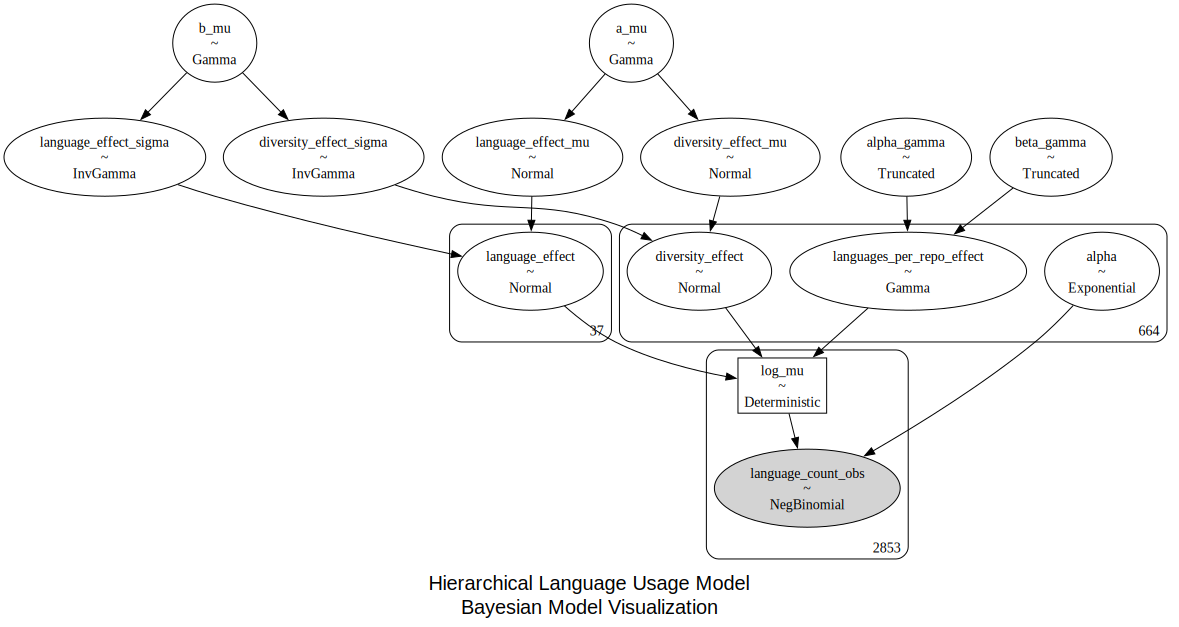

In [98]:
# Assuming 'language_usage_model' is your PyMC model
model_graph = pm.model_to_graphviz(language_usage_model)

# Customize the graph - Example changes
model_graph.attr(label='Hierarchical Language Usage Model\nBayesian Model Visualization')
model_graph.attr(fontsize='20', color='blue', fontname="Helvetica")

# Node and Edge customizations
with model_graph.subgraph() as s:
    s.attr(rank='same')
    # Customize nodes
    s.node_attr.update(color='lightblue2', style='filled', fontname="Helvetica")
    # Customize edges
    s.edge_attr.update(color='gray', arrowsize='0.5')

# Render the graph 
model_graph


In [ ]:
# Fiting the model - using nutpie for faster sampling
# Im using nutpie here as i dont have a gpu available -> change to take advantage.

with language_usage_model:
    trace = pm.sample(30000, tune=500, return_inferencedata=True, nuts_sampler="nutpie")

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\elemwise.py:754: RuntimeWarning:

divide by zero encountered in divide

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning:

Loop fusion failed because the resulting node would exceed the kernel argument limit.

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\elemwise.py:754: RuntimeWarning:

divide by zero encountered in divide

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\elemwise.py:754: RuntimeWarning:

divide by zero encountered in divide

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning:

Loop fus

## Model Diagnostics
 - Checking model convergence (e.g., trace plots, R-hat statistics)
Posterior predictive checks


In [ ]:
#Summary stats for the language.
# Extract unique language to language code mappings and sort by Language_codes
language_to_code_sorted = df[['Language', 'Language_codes']].drop_duplicates().sort_values(by='Language_codes').set_index('Language')['Language_codes'].to_dict()
print(az.summary(trace, var_names="language_effect"))
az.plot_posterior(trace, var_names=["language_effect"])

# Plotting
axes = az.plot_forest(
    trace,
    kind='ridgeplot',
    var_names=["language_effect"],
    figsize=(10, 10),
    combined=True,
    ridgeplot_overlap=3,
    colors="cycle",
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
)

# Assuming the first (or only) axis corresponds to the 'language_effect' variable
axes[0].set_yticklabels(language_to_code_sorted)


##  Results and Interpretation
- Extracting and summarizing the posterior distributions of model parameters
- Identifying significant factors and their impacts on language usage risk metrics
- Ridge plots for visualizing the distribution of language usage across projects and repositories, highlighting potential outliers or risks
- Additional plots for deeper insights (e.g., comparison of language usage trends across different organizational levels)

#### Key Considerations:

- **Credible Intervals and Outliers**: Narrow credible intervals suggest high parameter estimate certainty, while wide intervals indicate areas needing further investigation. Outlier detection can pinpoint innovative areas or non-standard practices for strategic exploration.

- **Decision-Making**: Insights from the HBM should inform strategic decisions regarding technology adoption, project management, and training to align coding practices with organizational goals, enhancing project continuity and adaptability.

This combined understanding of HBM principles, model structure, and practical implications equips readers with the knowledge to interpret complex data analyses meaningfully, driving informed decision-making within the organisation.

## Streamlit app

In [ ]:
trace

In [ ]:
# Model construction with the new logic
with pm.Model() as language_usage_model:
    # Organisational-level hyperpriors
    a_mu = pm.Gamma('a_mu', alpha=1.0, beta=1.0)
    b_mu = pm.Gamma('b_mu', alpha=1.0, beta=1.0)
    a_kappa = pm.Gamma('a_kappa', alpha=1.0, beta=0.1)
    b_kappa = pm.Gamma('b_kappa', alpha=1.0, beta=0.1)

    # Language-Level Priors
    language_effect = pm.Normal('language_effect', mu=0, sigma=1, shape=n_languages)

    # Project-level priors
    mu_project = pm.Beta('mu_project', alpha=a_mu, beta=b_mu, shape=n_projects)
    kappa_project = pm.Gamma('kappa_project', alpha=a_kappa, beta=b_kappa, shape=n_projects)

    # # Repository-level effects to associate repositories with projects
    # alpha_repo = mu_project[project_idx] * kappa_project[project_idx]
    # beta_repo = (1 - mu_project[project_idx]) * kappa_project[project_idx]
    # theta_repo = pm.Beta('theta_repo', alpha=alpha_repo, beta=beta_repo, shape=n_project_repos)  
    
    # # Adjusted Repository-Level Likelihood
    # mu_repo_lang = theta_repo[repo_to_project_idx] + language_effect[languages_idx]

     # Adjusting repository-level effects: Instead of defining a separate theta_repo, directly calculate alpha and beta for each observation
    alpha_obs = mu_project[project_idx] * kappa_project[project_idx]
    beta_obs = (1 - mu_project[project_idx]) * kappa_project[project_idx]

    # Directly model observed data without a separate theta_repo parameter
    mu_repo_lang = pm.Deterministic('mu_repo_lang', alpha_obs + language_effect[languages_idx])

   
    # Dispersion parameter and Negative Binomial distribution for observed byte counts
    dispersion_factor = pm.Exponential('dispersion_factor', lam=1.0)
    language_count = pm.NegativeBinomial('language_count', 
                                         mu=np.exp(mu_repo_lang), 
                                         alpha=dispersion_factor, 
                                         observed=byte_count)